삭제된 포스트 체크 하는 파일 

* 이슈  
    * postwithdeleted테이블에는 있지만 db에 있는 post테이블에는 없는 질의 응답 존재 
    * 예시 아이디 > 2335608
    * db에 있는 데이터와 SEDE에 있는 데이터를 짬뽕해서는 숫자를 맞출 수 없음 
    * 그래서 SEDE에 있는 데이터 만드로 확인 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import re
from collections import deque
import datetime

In [3]:
postwithdeleted = pd.read_csv('../../data/postwithdeleted.csv')

In [4]:
# 파일 불러오기
with open('../../data/df_body.pkl', 'rb') as f:
    df_body = pickle.load(f)


In [5]:
df_body['date'] = df_body['creationdate'].dt.date
df_body['year'] = df_body['creationdate'].dt.year
df_body['month'] = df_body['creationdate'].dt.month
df_body['day'] = df_body['creationdate'].dt.day

In [6]:
# Q&A 만 추출 
df_body = df_body[df_body['posttypeid'].isin(['1','2'])]
df_qna_num = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [8]:
df_bodycnt = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [9]:
df_bodycnt = pd.pivot_table(df_bodycnt, index = 'date', columns = 'posttypeid', values = 'id').reset_index()

In [10]:
df_bodycnt

posttypeid,date,1,2
0,2013-11-01,5614.0,9372.0
1,2013-11-02,3314.0,5248.0
2,2013-11-03,3537.0,5489.0
3,2013-11-04,6188.0,9585.0
4,2013-11-05,6566.0,10671.0
...,...,...,...
3677,2023-11-26,1811.0,1522.0
3678,2023-11-27,3201.0,2601.0
3679,2023-11-28,3416.0,2809.0
3680,2023-11-29,3519.0,2869.0


In [11]:
postwithdeleted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22412 entries, 0 to 22411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        22412 non-null  object
 1   posttypeid  22412 non-null  int64 
 2   del_yn      22412 non-null  object
 3   tot_cnt     22412 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 700.5+ KB


In [12]:
postwithdeleted['date_mod'] = pd.to_datetime(postwithdeleted['date'])


In [13]:
postwithdeleted = postwithdeleted.sort_values(by = ['date_mod'], ascending=True).reset_index(drop=True)

In [14]:
postwithdeleted_pivot = pd.pivot_table(data = postwithdeleted, index='date_mod', columns=['posttypeid', 'del_yn'], values = ['tot_cnt']).reset_index()

In [15]:
postwithdeleted_pivot.head()

date_mod tot_cnt                    
posttypeid                  1            2       
del_yn                      N     Y      N      Y
0          2008-07-31     4.0   2.0    2.0    4.0
1          2008-08-01    48.0  14.0   89.0  112.0
2          2008-08-02    25.0  22.0   68.0  197.0
3          2008-08-03    33.0  21.0   97.0  158.0
4          2008-08-04    77.0  49.0  238.0  465.0

In [16]:
postwithdeleted_pivot.columns

MultiIndex([('date_mod', '',  ''),
            ( 'tot_cnt',  1, 'N'),
            ( 'tot_cnt',  1, 'Y'),
            ( 'tot_cnt',  2, 'N'),
            ( 'tot_cnt',  2, 'Y')],
           names=[None, 'posttypeid', 'del_yn'])

In [17]:
postwithdeleted_pivot.columns = ['date_mod', 'q_cnt', 'q_d_cnt', 'a_cnt', 'a_d_cnt']

In [18]:
postwithdeleted_pivot.head()

,date_mod,q_cnt,q_d_cnt,a_cnt,a_d_cnt
0,2008-07-31,4.0,2.0,2.0,4.0
1,2008-08-01,48.0,14.0,89.0,112.0
2,2008-08-02,25.0,22.0,68.0,197.0
3,2008-08-03,33.0,21.0,97.0,158.0
4,2008-08-04,77.0,49.0,238.0,465.0


In [19]:
postwithdeleted_pivot['tot_d_cnt'] = postwithdeleted_pivot['q_d_cnt']+postwithdeleted_pivot['a_d_cnt']
postwithdeleted_pivot['tot_qna_cnt'] = postwithdeleted_pivot['q_cnt']+postwithdeleted_pivot['a_cnt']

In [24]:
postwithdeleted_pivot['tot_q_cnt'] = postwithdeleted_pivot['q_cnt']+postwithdeleted_pivot['q_d_cnt']
postwithdeleted_pivot['tot_a_cnt'] = postwithdeleted_pivot['a_cnt']+postwithdeleted_pivot['a_d_cnt']

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_14778/273757905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postwithdeleted_pivot['tot_q_cnt'] = postwithdeleted_pivot['q_cnt']+postwithdeleted_pivot['q_d_cnt']
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_14778/273757905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postwithdeleted_pivot['tot_a_cnt'] = postwithdeleted_pivot['a_cnt']+postwithdeleted_pivot['a_d_cnt']


In [21]:
postwithdeleted_pivot['ad_over_qd'] = postwithdeleted_pivot['a_d_cnt']/ postwithdeleted_pivot['q_d_cnt']

In [22]:
postwithdeleted_pivot = postwithdeleted_pivot[postwithdeleted_pivot['date_mod']>='2013-11-30']

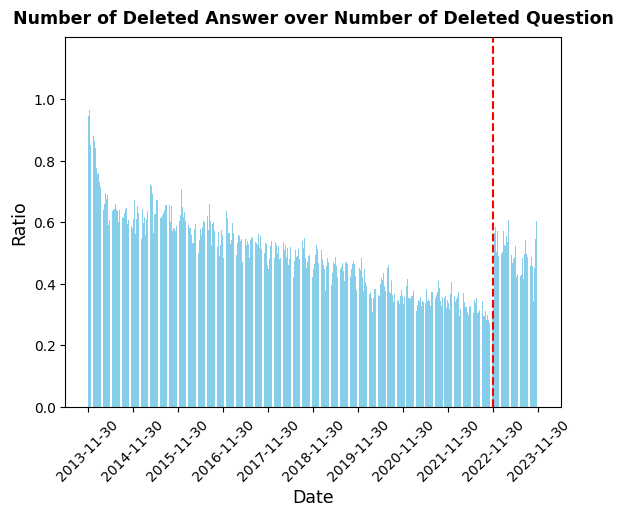

In [23]:
fig, ax = plt.subplots()


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['ad_over_qd']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Number of Deleted Answer over Number of Deleted Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

In [25]:
postwithdeleted_pivot['atot_over_qtot'] = postwithdeleted_pivot['tot_a_cnt']/ postwithdeleted_pivot['tot_q_cnt']

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_14778/2535964325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postwithdeleted_pivot['atot_over_qtot'] = postwithdeleted_pivot['tot_a_cnt']/ postwithdeleted_pivot['tot_q_cnt']


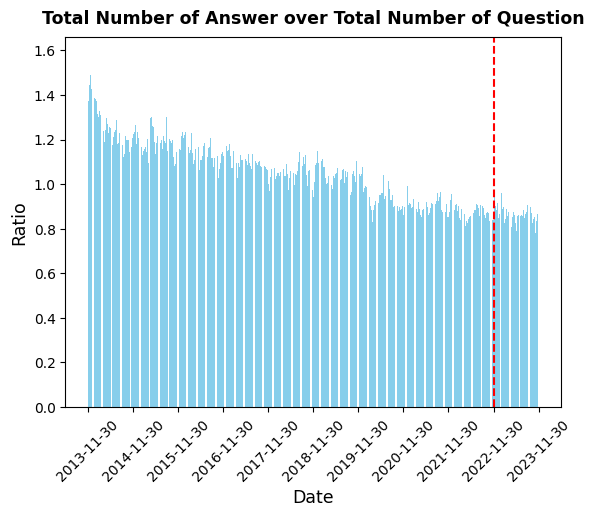

In [27]:
fig, ax = plt.subplots()


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['atot_over_qtot']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Total Number of Answer over Total Number of Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

In [28]:
postwithdeleted_pivot[postwithdeleted_pivot['date_mod']>= '2022-11-30'].head(20)

,date_mod,q_cnt,q_d_cnt,a_cnt,a_d_cnt,tot_d_cnt,tot_qna_cnt,ad_over_qd,tot_q_cnt,tot_a_cnt,atot_over_qtot
5235,2022-11-30,4190.0,3387.0,5331.0,1038.0,4425.0,9521.0,0.306466,7577.0,6369.0,0.840570
5236,2022-12-01,4285.0,3378.0,5153.0,1141.0,4519.0,9438.0,0.337774,7663.0,6294.0,0.821349
5237,2022-12-02,4759.0,1998.0,5026.0,1542.0,3540.0,9785.0,0.771772,6757.0,6568.0,0.972029
5238,2022-12-03,2935.0,1485.0,2989.0,1609.0,3094.0,5924.0,1.083502,4420.0,4598.0,1.040271
5239,2022-12-04,2913.0,1584.0,2950.0,1810.0,3394.0,5863.0,1.142677,4497.0,4760.0,1.058483
5240,2022-12-05,4957.0,2191.0,4816.0,1742.0,3933.0,9773.0,0.795071,7148.0,6558.0,0.917459
5241,2022-12-06,5299.0,2280.0,5240.0,1770.0,4050.0,10539.0,0.776316,7579.0,7010.0,0.924924
5242,2022-12-07,5001.0,2111.0,5138.0,1509.0,3620.0,10139.0,0.714827,7112.0,6647.0,0.934618
5243,2022-12-08,4868.0,1947.0,5030.0,1488.0,3435.0,9898.0,0.764253,6815.0,6518.0,0.956420
5244,2022-12-09,4261.0,1800.0,4499.0,1018.0,2818.0,8760.0,0.565556,6061.0,5517.0,0.910246


NameError: name 'df_qna_d_merge' is not defined

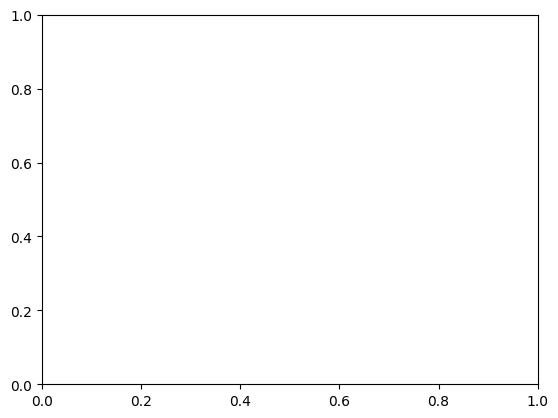

In [29]:
fig, ax = plt.subplots()


ax.bar(df_qna_d_merge.ddate_mod
    ,  height = df_qna_d_merge['a_d_cnt']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Ratio of Answered Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

In [30]:
df_qna_d_merge['a_d_over_q_d'] = df_qna_d_merge['a_d_cnt']/df_qna_d_merge['q_d_cnt']

NameError: name 'df_qna_d_merge' is not defined

In [ ]:
fig, ax = plt.subplots()


ax.bar(df_qna_d_merge.ddate_mod
    ,  height = df_qna_d_merge['a_d_over_q_d']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Ratio of Answered Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();